# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel, AdamW

import time
from tqdm.notebook import tqdm


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)



cuda:0


# Data Preprocessing

In [2]:
# This cell is to read the data and create a balanced dataset if needed

# size = 100
df = pd.read_csv('/kaggle/input/combined-dataset/data.csv', usecols=['text', 'generated'], )
# df_0 = df[df['generated'] == 0].sample(n=size//2, random_state=42)
# df_1 = df[df['generated'] == 1].sample(n=size//2, random_state=42)
# df = pd.concat([df_0, df_1]).reset_index(drop=True)

In [3]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128): 
    input_ids = [] 
    attention_masks = [] 

    for comment in comments: 
        encoded_dict = tokenizer.encode_plus( 
            comment,  
            add_special_tokens=True, 
            max_length=max_length, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors='pt'
        ) 

        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask']) 

    input_ids = torch.cat(input_ids, dim=0) 
    attention_masks = torch.cat(attention_masks, dim=0) 

    labels = torch.tensor(labels, dtype=torch.float32) 
    
    return input_ids, attention_masks, labels 



In [4]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df.text.tolist(), df.generated.tolist(), \
                                                  test_size=0.3, random_state=42, \
                                                  stratify=df.generated.tolist())

In [5]:
MAX_LEN = 400
BATCH_SIZE = 32
NUM_EPOCHS = 10

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

train_input_ids, train_attention_masks, train_labels = tokenize_and_encode( 
    tokenizer, 
    train_texts, 
    train_labels,
    max_length = MAX_LEN
) 

val_input_ids, val_attention_masks, val_labels = tokenize_and_encode( 
    tokenizer, 
    val_texts, 
    val_labels,
    max_length = MAX_LEN
) 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad

In [6]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels) 
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels) 


In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Model Construction

In [8]:
# MLP archetecture is [768, 512, 256, 128, 2]
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        # super helps in initializing the classes in the correct order when inheritance on it's own
        super(MLP, self).__init__()
        self.fc1  = nn.Linear(input_dim, hidden_dim1)
        self.fc2  = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3  = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4  = nn.Linear(hidden_dim3, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x
            
# This class passes the input into BERT model and then through the MLP layer
class CombinedModel(nn.Module):
    def __init__(self, bert_model, mlp):
        super(CombinedModel, self).__init__()
        self.bert = bert_model
        self.mlp = mlp

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.mlp(last_hidden_state)
        return logits

In [9]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
mlp = MLP(768, 512, 256, 128, 2)
model = CombinedModel(bert_model, mlp).to(device)

# AdamW  is a more efficient variant of Adam with sigmoid layer already present
# which means in our model, we don't 1 neuron in our final layer but 2
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
# loss function
loss_fn = nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
###########   Code for freezing BERT layers (computationally expensive)  ############
###########   add after initializing the bert model                      ############
#
# num_layers = len(bert_model.encoder.layer)  
# for i in range(0, num_layers):
#     if i >= num_layers - 0:
#         for param in bert_model.encoder.layer[i].parameters():
#             param.requires_grad = True
#     else:
#         for param in bert_model.encoder.layer[i].parameters():/
#             param.requires_grad = False


# Training

In [11]:
'''
    This function is used to train the model
    
'''
def train(model, train_loader, optimizer, loss_fn):
    # sets the model in training mode
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_loader):
        # move the data in batch to device
        input_ids, attention_mask, labels = [t.to(device) for t in batch]
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass
        outputs = model(input_ids, attention_mask=attention_mask) 
        # calculate the loss and then they are sent to device
        # (datatype of the loss should be same as the outputs)
        loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
        # compute the gradients of all optimized variables based on the loss
        loss.backward()
        # update the parameters based on the calculated gradients
        optimizer.step()

        train_loss += loss
        train_correct += (torch.max(outputs.data, dim=1)[1] == labels).sum().item()
        train_total += len(labels)
        
    
    train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    return train_loss, train_accuracy

def validation(model, val_loader, loss_fn):
    # set the model in evaluation mode
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            # move the data in batch to device
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            # calculate the loss
            loss = loss_fn(outputs.to(device), labels.type(torch.LongTensor).to(device))
            
            val_loss += loss
            val_correct += (torch.max(outputs.data, dim=1)[1] == labels).sum().item()
            val_total += len(labels)
            # get predicted labels assuming class 1 probability
            y_pred.extend(torch.softmax(outputs.data, dim=1)[:, 1].cpu().numpy())  
            y_true.extend(labels.cpu().numpy())
            
            val_correct += (torch.max(outputs.data, dim=1)[1] == labels).sum().item()
            val_total += len(labels)
    
    y_pred_label = [int(num >= 0.5) for num in y_pred]
    roc_auc = roc_auc_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred) 
    val_loss = val_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    return val_loss, val_accuracy, roc_auc, precision, recall, f1, fpr, tpr




In [12]:
# lists to store metrics
Tr_loss, Tr_acc, Vl_loss, Vl_acc = [], [], [], []
Vl_roc_auc, Vl_precision, Vl_recall, Vl_f1 = [], [], [], []
Vl_fpr, Vl_tpr = [], []

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch+1}")

    # train the model
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)

    # validate the model
    val_loss, val_acc, roc_auc, precision, recall, f1, fpr, tpr = validation(model, val_loader, loss_fn)
    
    # all the metrics is stored in lists for further analysis
    Tr_loss.append(train_loss.item())
    Tr_acc.append(train_acc)
    Vl_loss.append(val_loss.item())
    Vl_acc.append(val_acc)
    Vl_roc_auc.append(roc_auc)
    Vl_precision.append(precision)
    Vl_recall.append(recall)
    Vl_f1.append(f1)
    Vl_tpr.append(tpr)
    Vl_fpr.append(fpr)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"AOC ROC: {roc_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ")
    print("\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0024, Train Acc: 98.5450, Val Loss: 0.0013, Val Acc: 97.1241
AOC ROC: 0.9763, Precision: 0.9315, Recall: 0.9973, F1: 0.9633, 


Epoch 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 99.5768, Val Loss: 0.0006, Val Acc: 98.9188
AOC ROC: 0.9907, Precision: 0.9750, Recall: 0.9970, F1: 0.9859, 


Epoch 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 99.7683, Val Loss: 0.0006, Val Acc: 98.7675
AOC ROC: 0.9897, Precision: 0.9704, Recall: 0.9979, F1: 0.9839, 


Epoch 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 99.7776, Val Loss: 0.0004, Val Acc: 99.1062
AOC ROC: 0.9922, Precision: 0.9798, Recall: 0.9970, F1: 0.9883, 


Epoch 5


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 99.8301, Val Loss: 0.0002, Val Acc: 99.6540
AOC ROC: 0.9965, Precision: 0.9947, Recall: 0.9962, F1: 0.9954, 


Epoch 6


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 99.8486, Val Loss: 0.0003, Val Acc: 99.5531
AOC ROC: 0.9955, Precision: 0.9930, Recall: 0.9952, F1: 0.9941, 


Epoch 7


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 99.8455, Val Loss: 0.0002, Val Acc: 99.5603
AOC ROC: 0.9943, Precision: 0.9996, Recall: 0.9888, F1: 0.9942, 


Epoch 8


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 99.9413, Val Loss: 0.0002, Val Acc: 99.7477
AOC ROC: 0.9970, Precision: 0.9983, Recall: 0.9950, F1: 0.9967, 


Epoch 9


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 99.9846, Val Loss: 0.0002, Val Acc: 99.7405
AOC ROC: 0.9973, Precision: 0.9962, Recall: 0.9970, F1: 0.9966, 


Epoch 10


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 99.8764, Val Loss: 0.0002, Val Acc: 99.6612
AOC ROC: 0.9966, Precision: 0.9943, Recall: 0.9968, F1: 0.9955, 




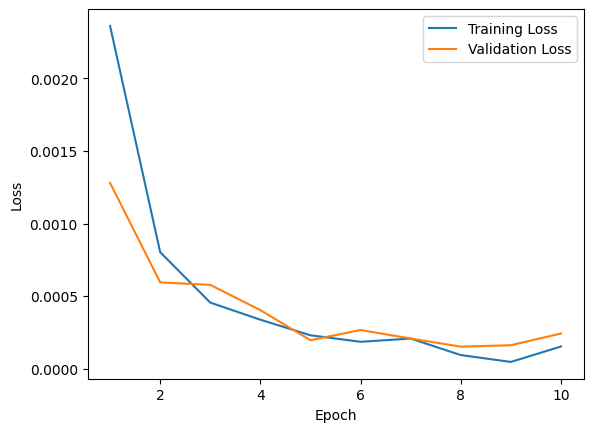

In [13]:
# Loss vs epoch

plt.plot(range(1, NUM_EPOCHS+1), Tr_loss, label="Training Loss")
plt.plot(range(1, NUM_EPOCHS+1), Vl_loss, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

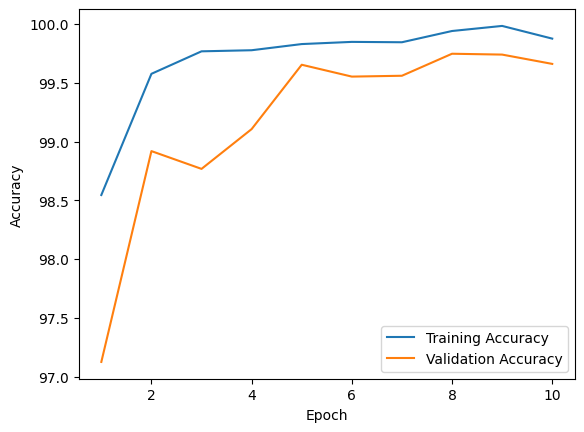

In [14]:
# Accuracy vs epoch

plt.plot(range(1, NUM_EPOCHS+1), Tr_acc, label="Training Accuracy")
plt.plot(range(1, NUM_EPOCHS+1), Vl_acc, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

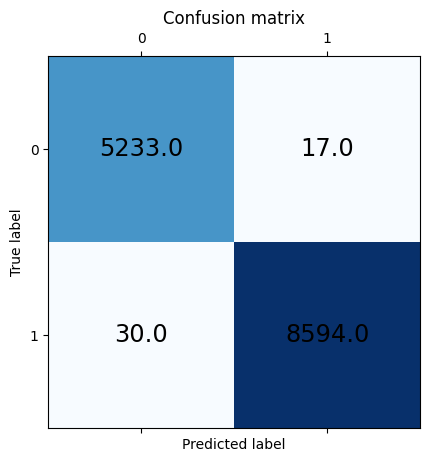

In [15]:
# calculating the Comfusion Matrix
def calculate_tp_tn_fp_fn(accuracy, precision, recall, total_entries):
    tp = np.round((1-accuracy) * total_entries / (1/precision + 1/recall -2))
    fn = np.round((1/recall - 1) *tp)
    fp = np.round((1/precision - 1) *tp)
    tn = np.round(total_entries - tp - fp - fn)
    return tp, fn, fp, tn
array = np.array(calculate_tp_tn_fp_fn(Vl_acc[-1]/100, \
                                        Vl_precision[-1],\
                                        Vl_recall[-1], \
                                        len(val_texts)))
matrix = np.array([[array[0], array[1]], [array[2], array[3]]])

plt.matshow(matrix * 1/len(val_texts), cmap=plt.cm.Blues, )

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(x=j, y=i,s=matrix[i, j], va='center', ha='center', size='xx-large')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

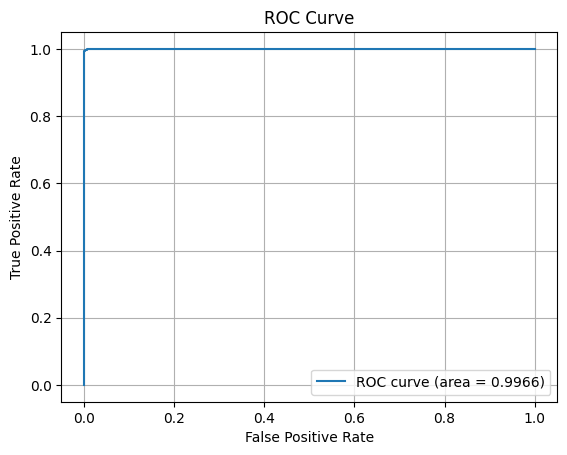

In [16]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.legend(loc="lower right")


# Saving Model details and metrics

In [17]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': Tr_loss,
    'train_acc': Tr_acc,
    'val_loss': Vl_loss,
    'val_acc': Vl_acc,
    'val_roc_auc': Vl_roc_auc,
    'val_precision': Vl_precision,
    'val_recall': Vl_recall,
    'val_f1': Vl_f1,
    'val_tpr': Vl_tpr,
    'val_fpr': Vl_fpr,

}
torch.save(checkpoint, 'checkpoint.pth')
